In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [25]:
data = pd.read_excel("rfv_analise.xlsx")


In [47]:
data = pd.DataFrame(data)

In [58]:
data.tail(5)

,Ano,Rede,UF,BU,BU New,Canal VD-VI-Hosp,Trimestre,Mês,Entregue - Liq Abatimento,Qtd Entregue
85797,2022,CIRURGICA MONTEBELLO LTDA,PE,MARCAS,SANOFI PP,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0,0.0
85798,2022,CIRURGICA MONTEBELLO LTDA,PE,MARCAS,TAKEDA CH,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0,0.0
85799,2022,CIRURGICA MONTEBELLO LTDA,PE,MARCAS,TAKEDA PP,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0,0.0
85800,2022,CIRURGICA MONTEBELLO LTDA,PE,SMART,INSTITUCIONAL,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0,0.0
85801,2022,CIRURGICA MONTEBELLO LTDA,PE,SMART,SMART GENERICS,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0,0.0


In [73]:
data_features = data.loc[:, ['Ano', 'Rede', 'UF', "BU", "BU New", "Canal VD-VI-Hosp", "Trimestre", "Mês", 'Qtd Entregue']]

In [74]:
data_features

,Ano,Rede,UF,BU,BU New,Canal VD-VI-Hosp,Trimestre,Mês,Qtd Entregue
0,2018,DROGASIL,BA,Adoçantes,CONSUMER HEALTH,VAREJO DIRETO,1 TRIMESTRE,FEVEREIRO,0.0
1,2018,DROGASIL,BA,Adoçantes,CONSUMER HEALTH,VAREJO DIRETO,1 TRIMESTRE,MARÇO,0.0
2,2018,DROGASIL,BA,Adoçantes,CONSUMER HEALTH,VAREJO DIRETO,2 TRIMESTRE,ABRIL,0.0
3,2018,DROGASIL,BA,Adoçantes,CONSUMER HEALTH,VAREJO DIRETO,2 TRIMESTRE,MAIO,64.0
4,2018,DROGASIL,BA,Adoçantes,CONSUMER HEALTH,VAREJO DIRETO,2 TRIMESTRE,JUNHO,352.0
...,...,...,...,...,...,...,...,...,...
85797,2022,CIRURGICA MONTEBELLO LTDA,PE,MARCAS,SANOFI PP,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0
85798,2022,CIRURGICA MONTEBELLO LTDA,PE,MARCAS,TAKEDA CH,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0
85799,2022,CIRURGICA MONTEBELLO LTDA,PE,MARCAS,TAKEDA PP,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0
85800,2022,CIRURGICA MONTEBELLO LTDA,PE,SMART,INSTITUCIONAL,HOSPITALAR,4 TRIMESTRE,DEZEMBRO,0.0


In [75]:
data_target = data.loc[:, ['Entregue - Liq Abatimento']]

In [76]:
data_target

,Entregue - Liq Abatimento
0,0.00
1,0.00
2,0.00
3,5386.33
4,25947.19
...,...
85797,0.00
85798,0.00
85799,0.00
85800,0.00


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


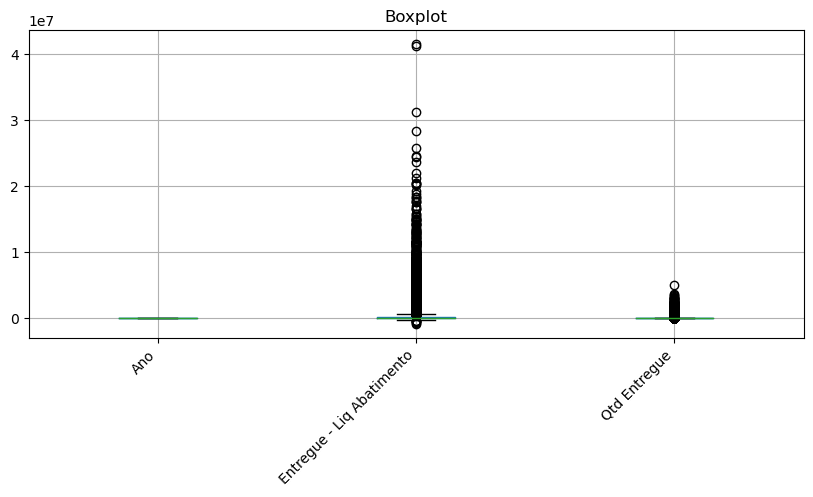

In [84]:
data.boxplot(figsize=(10, 4));
plt.title('Boxplot')
plt.xticks(rotation=45, ha='right');

In [85]:
data.isnull().sum()

Ano                          0
Rede                         0
UF                           0
BU                           0
BU New                       0
Canal VD-VI-Hosp             0
Trimestre                    0
Mês                          0
Entregue - Liq Abatimento    0
Qtd Entregue                 0
dtype: int64

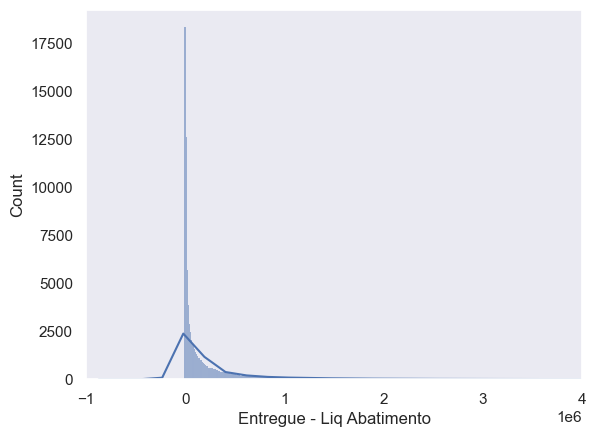

In [107]:
sns.histplot(data=data, x='Entregue - Liq Abatimento', kde=True )
plt.xlim([-1000000, 4000000])

plt.show()

In [92]:
data["Entregue - Liq Abatimento"].skew()

10.726830418083939

In [95]:
data["Log - Liq Abatimento"] = np.log10(data["Entregue - Liq Abatimento"])
data[["Log - Liq Abatimento", "Entregue - Liq Abatimento"]]

,Log - Liq Abatimento,Entregue - Liq Abatimento
0,-inf,0.00
1,-inf,0.00
2,-inf,0.00
3,3.731293,5386.33
4,4.414090,25947.19
...,...,...
85797,-inf,0.00
85798,-inf,0.00
85799,-inf,0.00
85800,-inf,0.00


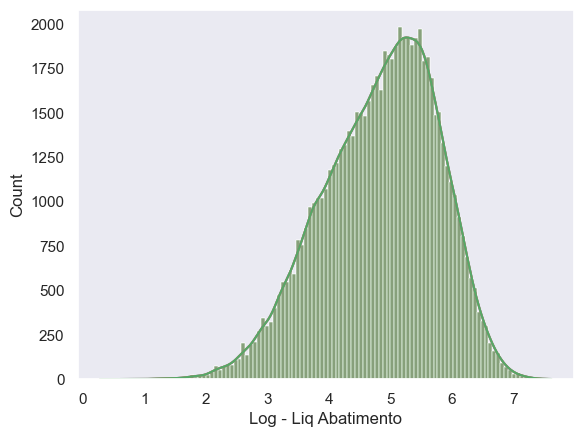

In [98]:
sns.histplot(data=data, x='Log - Liq Abatimento', kde=True )
plt.show()

In [114]:
data.isnull().sum()

Ano                            0
Rede                           0
UF                             0
BU                             0
BU New                         0
Canal VD-VI-Hosp               0
Trimestre                      0
Mês                            0
Entregue - Liq Abatimento      0
Qtd Entregue                   0
Log - Liq Abatimento         205
dtype: int64

In [116]:
correlacao = data.corr(method='spearman', numeric_only=True)
correlacao

,Ano,Entregue - Liq Abatimento,Qtd Entregue,Log - Liq Abatimento
Ano,1.000000,0.195049,0.152973,0.098734
Entregue - Liq Abatimento,0.195049,1.000000,0.936346,1.000000
Qtd Entregue,0.152973,0.936346,1.000000,0.888514
Log - Liq Abatimento,0.098734,1.000000,0.888514,1.000000


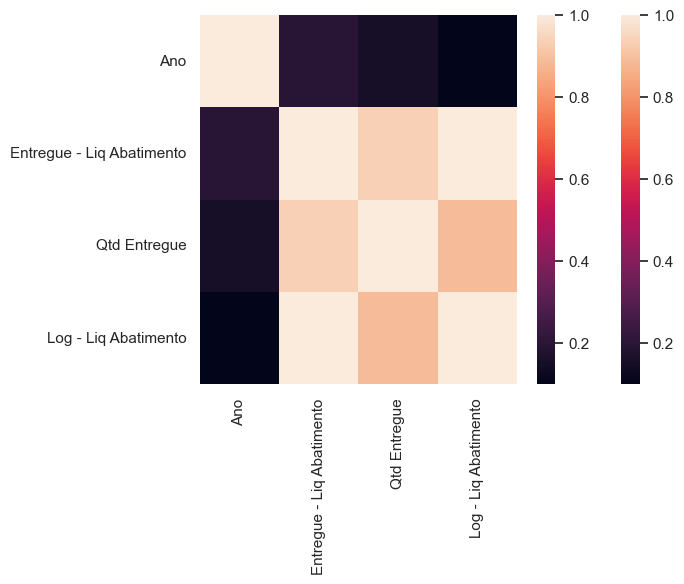

In [118]:
sns.heatmap(correlacao)
plt.show()

In [119]:
corr_abs = correlacao['Entregue - Liq Abatimento'].abs().sort_values(ascending=False)
corr_abs

Entregue - Liq Abatimento    1.000000
Log - Liq Abatimento         1.000000
Qtd Entregue                 0.936346
Ano                          0.195049
Name: Entregue - Liq Abatimento, dtype: float64

In [120]:
corr_abs[corr_abs>0.5]

Entregue - Liq Abatimento    1.000000
Log - Liq Abatimento         1.000000
Qtd Entregue                 0.936346
Name: Entregue - Liq Abatimento, dtype: float64

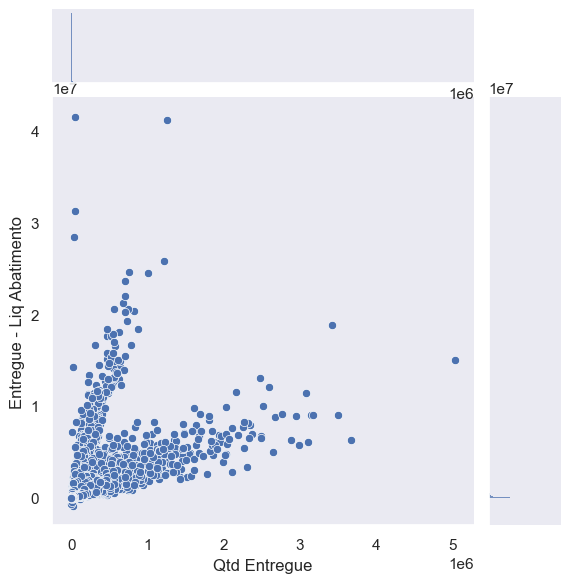

In [122]:
sns.jointplot(data=data, x='Qtd Entregue', y='Entregue - Liq Abatimento')
plt.show()

In [123]:
X = data[['Entregue - Liq Abatimento']]
y = data['Qtd Entregue']

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [125]:
model = LinearRegression()

In [126]:
model.fit(X_train, y_train)

LinearRegression()

In [127]:
vars(model)

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['Entregue - Liq Abatimento'], dtype=object),
 'n_features_in_': 1,
 'coef_': array([0.06548167]),
 '_residues': 442561886840190.06,
 'rank_': 1,
 'singular_': array([2.25733404e+08]),
 'intercept_': 8859.01553438662}

In [128]:
print(f'Coeficiente linear: {model.intercept_}')

Coeficiente linear: 8859.01553438662


In [129]:
print(f'Coeficiente angular: {model.coef_[0]}')

Coeficiente angular: 0.06548167146722134


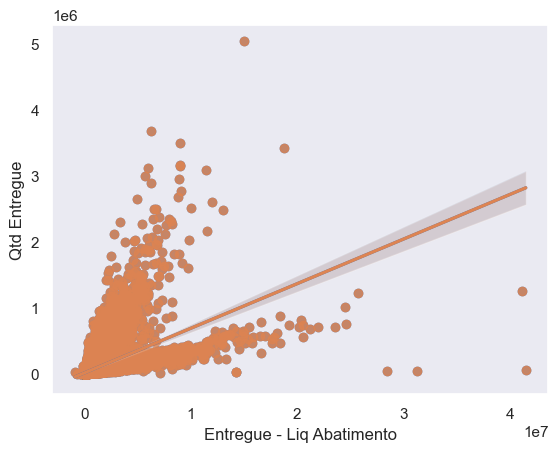

In [132]:
sns.regplot(data=data, x='Entregue - Liq Abatimento', y='Qtd Entregue')
plt.show()

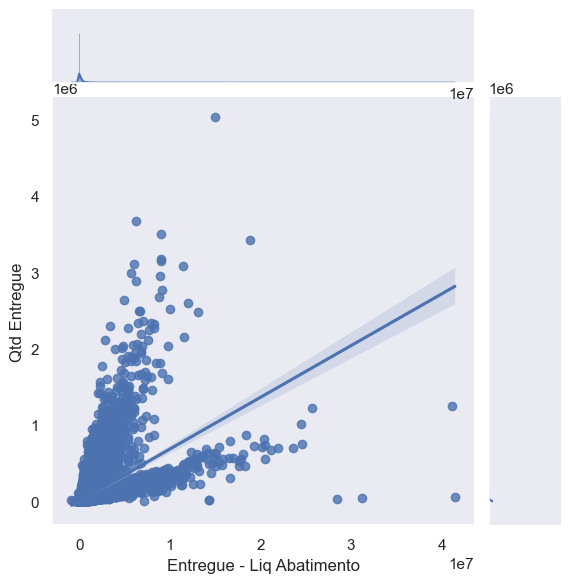

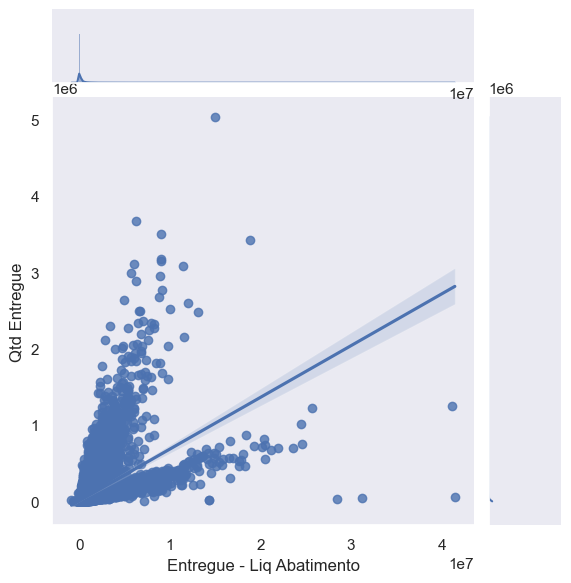

In [135]:
sns.jointplot(data=data, x='Entregue - Liq Abatimento', y='Qtd Entregue', kind='reg')
plt.show()